In [189]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [190]:
def mascara(imagen):
    puntos_referencia = np.array([(1, 374), (1231, 374),(705, 176) ,(501, 176) ], dtype=np.int32)
    mascara = np.zeros_like(imagen)
    cv2.fillPoly(mascara, [puntos_referencia], (255, 255, 255)) 
    imagen_resultado = cv2.bitwise_and(imagen, mascara)
    return imagen_resultado

In [191]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [192]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

In [193]:
def kernel_gaussiano (img):
    mascara = np.array([[1, 4,  7,  4,  1], 
                        [4, 16, 26, 16, 4], 
                        [7, 26, 41, 26, 7],
                        [4, 16, 26, 16, 4],
                        [1, 4,  7,  4,  1]])

    mascara = mascara /273  #normalización de la mascar
    mascaraf, mascaraC = mascara.shape

    filas,columnas,canales = img.shape# obtención de los tamaños de las imagenes 
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)

    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1),canales))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal[i-bordeH, j-bordeA, 0] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 0])
            matrizfinal[i-bordeH, j-bordeA, 1] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 1])
            matrizfinal[i-bordeH, j-bordeA, 2] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 2])

    return matrizfinal

In [194]:
def Gradientes (imgarr):
    filas,columnas,ca = imgarr.shape
    #La imagen se convierte a escala de grises 
    img = np.dot(imgarr[...,:3], [0.299, 0.587, 0.114])

    h,w=img.shape

    mascara_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])

    mascara_y = np.array([[-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])

    mascaraf, mascaraC = mascara_x.shape
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)
    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1)))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal_x = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 
    matrizfinal_y = np.zeros_like(img)
    gradiente = np.zeros_like(img)
    gradiente_angulo = np.zeros_like(img)

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal_x[i-bordeH, j-bordeA] = np.sum(mascara_x * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            matrizfinal_y[i-bordeH, j-bordeA] = np.sum(mascara_y * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            gradiente[i-bordeH, j-bordeA] = np.sqrt((matrizfinal_x[i-bordeH, j-bordeA]**2) + (matrizfinal_y[i-bordeH, j-bordeA]**2))
            gradiente_angulo[i-bordeH, j-bordeA] = np.arctan2(matrizfinal_y[i-bordeH, j-bordeA], matrizfinal_x[i-bordeH, j-bordeA])
            
    return gradiente, gradiente_angulo

In [195]:
def supresionM(gradiente_magnitud, gradiente_angulo):
    filas, columnas = gradiente_magnitud.shape
    maximosl = np.zeros_like(gradiente_magnitud)
    #Obtenemos los grads que tiene cada pixel
    angulos = gradiente_angulo * 180 / np.pi
    #Nos aseguramos que se encuentre dentro del rango de 0 a 180
    angulos[angulos < 0] += 180

    for i in range(1, filas - 1):
        for j in range(1, columnas - 1):
            #Verificación de los ángulos de capa pixel
            if ( 0 <= angulos[i,j] < 22.5) or ( 157.5 <= angulos[i,j]< 180):
                cercanos =  (gradiente_magnitud[i,j-1], gradiente_magnitud[i, j], gradiente_magnitud[i, j + 1])
            elif (22.5 <= angulos[i,j] < 67.5):
                cercanos = (gradiente_magnitud[i - 1, j - 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j + 1])
            elif (67.5 <= angulos[i,j] < 112.5):
                cercanos = (gradiente_magnitud[i - 1, j], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j])
            else:
                cercanos = (gradiente_magnitud[i - 1, j + 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j - 1])
            if (gradiente_magnitud[i,j]>= max(cercanos)):
                maximosl[i,j] = gradiente_magnitud[i,j]

    return maximosl



In [196]:
def umbralizacion_histeresis(gradiente_suprimido, umbral_bajo, umbral_alto):
    # Aplicar la umbralización por histéresis
    bordes_fuertes = gradiente_suprimido > umbral_alto
    bordes_debiles = (gradiente_suprimido >= umbral_bajo) & (gradiente_suprimido <= umbral_alto)

    etiquetas, num_caracteristicas = ndimage.label(bordes_fuertes)

    for i in range(1, num_caracteristicas + 1):
        etiqueta_actual = (etiquetas == i)
        bordes_debiles = bordes_debiles | etiqueta_actual

    return bordes_fuertes, bordes_debiles

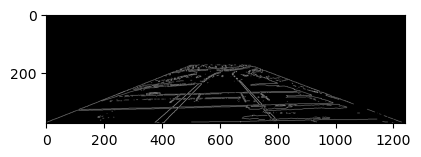

In [197]:
image = cv2.imread('carretera8.png')

cropped_image = mascara(image)
blur = kernel_gaussiano(cropped_image)

gradiente, gradienteAng = Gradientes(blur)
gradienteS = supresionM(gradiente, gradienteAng)

umbral_bajo = 50
umbral_alto = 150
bordes_fuertes, bordes_debiles = umbralizacion_histeresis(gradienteS, umbral_bajo, umbral_alto)

imagen_binaria = np.where(bordes_debiles > 0, 1, 0)

plt.subplot(3, 1, 2)
plt.imshow(imagen_binaria, cmap='gray')

In [198]:
print(imagen_binaria.dtype)  # Should print "uint8" for 8-bit image
print(imagen_binaria.shape)

int32
(376, 1241)


In [199]:
imagen_binaria = imagen_binaria.astype(np.uint8)

In [200]:
lines = cv2.HoughLines(imagen_binaria, rho=1, theta=np.pi/180, threshold=100)
print(lines)

[[[ 381.            1.553343  ]]

 [[ 331.            1.553343  ]]

 [[ 337.            1.5358897 ]]

 [[ 301.            1.553343  ]]

 [[ 339.            1.5358897 ]]

 [[ 293.            1.5358897 ]]

 [[ 284.            1.553343  ]]

 [[ 282.            1.553343  ]]

 [[ 333.            1.553343  ]]

 [[ 324.            1.5707964 ]]

 [[ 348.            1.1868238 ]]

 [[ -90.            1.9373155 ]]

 [[ 270.            1.5707964 ]]

 [[ 286.            1.553343  ]]

 [[-352.            2.4260077 ]]

 [[ 343.            1.2740903 ]]

 [[ 325.            1.553343  ]]

 [[ 531.            0.83775806]]

 [[ 312.            1.5358897 ]]

 [[ 552.            0.7853982 ]]

 [[ 359.            1.5358897 ]]

 [[ 334.            1.5358897 ]]

 [[ 283.            1.4835298 ]]

 [[ 553.            0.7679449 ]]

 [[ 299.            1.553343  ]]

 [[ 364.            1.5707964 ]]

 [[ 346.            1.2042772 ]]

 [[ 345.            1.2566371 ]]

 [[-334.            2.3911011 ]]

 [[ 340.      

In [201]:
def houghLine(image):
   Ny = image.shape[0]
   Nx = image.shape[1]

   #Max diatance is diagonal one 
   Maxdist = int(np.round(np.sqrt(Nx**2 + Ny ** 2)))
   thetas = np.deg2rad(np.arange(-180, 180))
   #Range of radius
   rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
   accumulator = np.zeros((2 * Maxdist, len(thetas)))
   for y in range(Ny):
      for x in range(Nx):
         # Check if it is an edge pixel
         #  NB: y -> rows , x -> columns
         if image[y,x] > 0:
            for k in range(len(thetas)):
               r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
               accumulator[int(r) + Maxdist,k] += 1
   return accumulator, thetas, rs

In [202]:

def find_lines(accumulator, threshold, rs, thetas, image):
    # Find peaks in the accumulator
    peaks = np.where(accumulator > threshold)
    lines = []
    for rho_idx, theta_idx in zip(peaks[0], peaks[1]):
        rho = rs[rho_idx]
        theta = thetas[theta_idx]
        
        # Convert polar coordinates (rho, theta) to Cartesian coordinates (x, y)
        x1 = int(rho * np.cos(theta))
        y1 = int(rho * np.sin(theta))
        x2 = int(x1 + 1000 * (-np.sin(theta)))  # Extend the line for visualization
        y2 = int(y1 + 1000 * (np.cos(theta)))  # Extend the line for visualization
        
        lines.append(((x1, y1), (x2, y2)))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
    return lines, image

In [203]:
Oimage=image
accumulator, thetas, rhos = houghLine(imagen_binaria)
threshold = 170  # Adjust the threshold as needed
detected_lines, Oimage = find_lines(accumulator, threshold, rhos, thetas, Oimage)
print(detected_lines)


[((6, 380), (1005, 362)), ((129, 321), (1056, -53)), ((11, 340), (1010, 305)), ((11, 339), (1010, 304)), ((11, 338), (1010, 303)), ((11, 337), (1010, 302)), ((11, 336), (1010, 301)), ((11, 335), (1010, 300)), ((5, 330), (1004, 312)), ((5, 329), (1004, 311)), ((5, 328), (1004, 310)), ((5, 327), (1004, 309)), ((0, 326), (1000, 326)), ((0, 323), (1000, 323)), ((10, 310), (1009, 275)), ((5, 300), (1004, 282)), ((10, 293), (1009, 258)), ((10, 292), (1009, 257)), ((10, 291), (1009, 256)), ((4, 283), (1003, 265)), ((4, 282), (1003, 264)), ((4, 280), (1003, 262)), ((0, 270), (-1000, 270)), ((4, 281), (-995, 298)), ((4, 283), (-995, 300)), ((4, 284), (-995, 301)), ((10, 292), (-989, 326)), ((10, 293), (-989, 327)), ((10, 294), (-989, 328)), ((5, 301), (-994, 318)), ((10, 311), (-989, 345)), ((0, 324), (-1000, 324)), ((5, 328), (-994, 345)), ((0, 328), (-1000, 328)), ((5, 329), (-994, 346)), ((5, 330), (-994, 347)), ((5, 331), (-994, 348)), ((11, 336), (-988, 370)), ((11, 337), (-988, 371)), ((1

In [204]:
cv2.imshow('Detected Lines', Oimage)
cv2.waitKey(0)
cv2.destroyAllWindows()